<a href="https://colab.research.google.com/github/GonzaloMA-17/k_brazos_FJLGM/blob/main/notebook1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estudio comparativo de algoritmos en un problema de bandido de k-brazos

### Resolución del Problema con Algoritmos Softmax

En este estudio, abordaremos el problema del bandido de k-brazos utilizando algoritmos Softmax. Este enfoque es una alternativa a los algoritmos epsilon-greedy y se basa en la probabilidad de seleccionar cada brazo en función de su valor estimado.

#### Algoritmos Softmax

A diferencia de los algoritmos epsilon-greedy, que seleccionan el mejor brazo conocido con una alta probabilidad y exploran otros brazos con una pequeña probabilidad, los algoritmos Softmax asignan una probabilidad a cada brazo basada en su valor estimado. Esto permite una exploración más equilibrada y puede mejorar el rendimiento en ciertos escenarios.

#### Objetivos del Estudio

En este estudio, compararemos el rendimiento de diferentes configuraciones del algoritmo Softmax en un entorno de bandido de 10 brazos. Para ello, realizaremos múltiples ejecuciones del experimento y generaremos las siguientes gráficas:

1. **Porcentaje de Selección del Brazo**: Mostraremos cómo varía el porcentaje de veces que cada brazo es seleccionado a lo largo del tiempo.
2. **Estadísticas de Cada Brazo**: Presentaremos el promedio de las ganancias obtenidas por cada brazo, lo que nos permitirá evaluar la efectividad de las selecciones.
3. **Evolución del Rechazo**: Analizaremos cómo evoluciona el rechazo acumulado (diferencia entre la recompensa óptima y la recompensa obtenida) a lo largo del tiempo.

Estas visualizaciones nos permitirán entender mejor el comportamiento de los algoritmos Softmax y su capacidad para equilibrar la exploración y la explotación en el problema del bandido de k-brazos.


## Preparación del entorno

**Clonación del repositorio:**

Para poder acceder a todas las clases y métodos necesarios.

In [2]:
# !git clone https://github.com/GonzaloMA-17/k_brazos_FJLGM.git

In [3]:
# %cd k_brazos_FJLGM

### Librerías

In [4]:
import numpy as np
from typing import List

from src_algorithms import Algorithm, Softmax, GradientPreference
from src_arms import *
from src_plotting import *

Semilla:

In [5]:
seed = 1234

**Definición del experimento:**

Cada algoritmo se ejecuta en un problema de k-armed bandit durante un número de pasos de tiempo y ejecuciones determinado. Se comparan los resultados de los algoritmos en términos de recompensa promedio.

Por ejemplo. Dado un bandido de k-brazos, se ejecutan dos algoritmos Softmax con diferentes valores de temperatura. Se estudia la evolución de cada política en un número de pasos, por ejemplo, mil pasos. Entonces se repite el experimento un número de veces, por ejemplo, 500 veces. Es decir, se ejecutan 500 veces la evolución de cada algoritmo en 1000 pasos. Para cada paso calculamos el promedio de las recompensas obtenidas en esas 500 veces.

In [6]:
def run_experiment(bandit: Bandit, algorithms: List[Algorithm], steps: int, runs: int):
    """
    Ejecuta experimentos comparativos entre diferentes algoritmos.

    :param bandit: Instancia de Bandit configurada para el experimento.
    :param algorithms: Lista de instancias de algoritmos a comparar.
    :param steps: Número de pasos de tiempo por ejecución.
    :param runs: Número de ejecuciones independientes.
    :return: Tuple de tres elementos: recompensas promedio, porcentaje de selecciones óptimas, y estadísticas de brazos.
    :rtype: Tuple of (np.ndarray, np.ndarray, list)
    """

    k = bandit.k
    optimal_arm = bandit.optimal_arm

    # Inicializar matrices para recompensas y selecciones óptimas
    rewards = np.zeros((len(algorithms), steps))
    optimal_selections = np.zeros((len(algorithms), steps))


    for run in range(runs):
        # Crear una nueva instancia del bandit para cada ejecución
        current_bandit = Bandit(arms=bandit.arms)

        # Obtener la recompensa esperada óptima
        q_max = current_bandit.get_expected_value(current_bandit.optimal_arm)

        for algo in algorithms:
            algo.reset()

        # Inicializar recompensas acumuladas por algoritmo para esta ejecución
        total_rewards_per_algo = np.zeros(len(algorithms))  # Para análisis por rechazo

        # Inicializar recompensas acumuladas por algoritmo para esta ejecución
        # cumulative_rewards_per_algo = np.zeros(len(algorithms))

        for step in range(steps):
            for idx, algo in enumerate(algorithms):
                chosen_arm = algo.select_arm()
                reward = current_bandit.pull_arm(chosen_arm)
                algo.update(chosen_arm, reward)

                rewards[idx, step] += reward
                total_rewards_per_algo[idx] += reward

                if chosen_arm == optimal_arm:
                    optimal_selections[idx, step] += 1

    # Promediar las recompensas y el regret sobre todas las ejecuciones
    rewards /= runs
    optimal_selections = (optimal_selections / runs) * 100

    return rewards, optimal_selections

**Ejecución del experimento**:

Se realiza el experimento usando 10 brazos, cada uno de acuerdo a una distribución Binomial con parámetros **n y p**. 

Se realizan 500 ejecuciones de 1000 pasos cada una. Se contrastan dos algoritmos de la familia de **Ascenso del gradiente**: 

- *Softmax*
- *Gradiente de preferencias*.

In [7]:
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmNormal.generate_arms(k)) # Generar un bandido con k brazos de distribución normal
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 3 algoritmos epsilon-greedy con diferentes valores de epsilon.
algorithms = [Softmax(k=k, tau=0.1),Softmax(k=k, tau=1), GradientPreference(k=k, alpha=0.1), GradientPreference(k=k, alpha=0.5)]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections = run_experiment(bandit, algorithms, steps, runs)

Bandit with 10 arms: ArmNormal(mu=2.72, sigma=1.0), ArmNormal(mu=3.45, sigma=1.0), ArmNormal(mu=4.94, sigma=1.0), ArmNormal(mu=3.49, sigma=1.0), ArmNormal(mu=6.6, sigma=1.0), ArmNormal(mu=8.07, sigma=1.0), ArmNormal(mu=8.02, sigma=1.0), ArmNormal(mu=8.22, sigma=1.0), ArmNormal(mu=9.62, sigma=1.0), ArmNormal(mu=8.88, sigma=1.0)
Optimal arm: 9 with expected reward=9.62


**Visualización de resultados**:

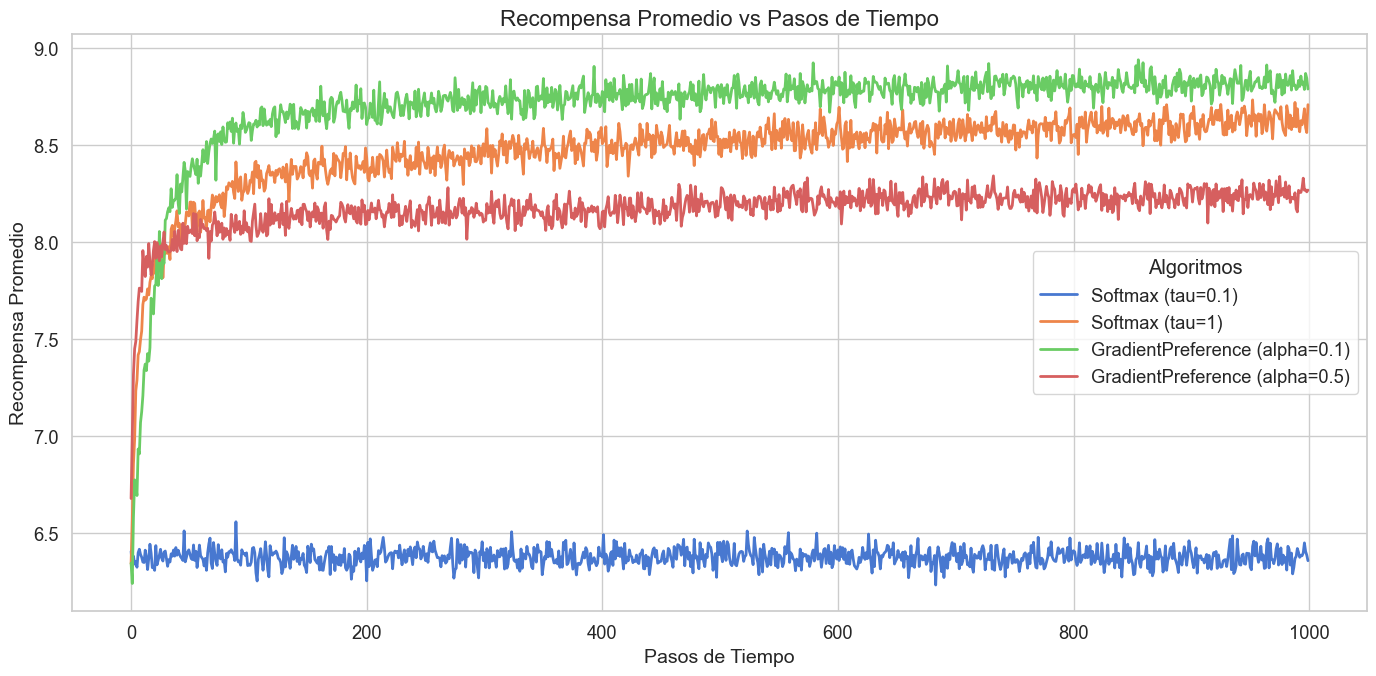

In [8]:
# Graficar los resultados
plot_average_rewards(steps, rewards, algorithms)
# plot_optimal_selections(steps, optimal_selections, algorithms)

**Análisis de la Recompensa Promedio en Función del Tiempo**

**Descripción de los Algoritmos y Configuraciones:**

- Softmax (τ = 0.1) - Azul: Baja exploración, favorece la explotación temprana.

- Softmax (τ = 1) - Naranja: Mayor exploración, lo que permite evaluar más opciones antes de explotar.

- Gradiente de Preferencias (α = 0.1) - Verde: Tasa de aprendizaje baja, lo que permite un ajuste gradual y estable de las preferencias.

- Gradiente de Preferencias (α = 0.5) - Rojo: Tasa de aprendizaje alta, lo que permite una adaptación rápida pero puede llevar a convergencia prematura en una política subóptima.

**Análisis de Resultados**

1. Crecimiento y Convergencia de la Recompensa Promedio

- El Gradiente de Preferencias con α = 0.1 (verde) obtiene la mejor recompensa promedio final. Su menor tasa de aprendizaje permite una convergencia más estable y efectiva hacia los brazos óptimos.

- El Gradiente de Preferencias con α = 0.5 (rojo) converge más rápido pero alcanza una recompensa menor. Su mayor tasa de aprendizaje ajusta las preferencias rápidamente, pero puede llevar a decisiones precipitadas sin explorar suficientemente todas las opciones.

- Softmax con τ = 1 (naranja) obtiene una recompensa promedio mayor que Softmax con τ = 0.1 (azul). La mayor exploración inicial de τ = 1 le permite evitar caer en elecciones subóptimas, pero no logra alcanzar la recompensa final del Gradiente de Preferencias con α = 0.1.

2. Equilibrio entre Exploración y Explotación

- Gradiente de Preferencias ajusta dinámicamente las probabilidades de selección de los brazos, lo que resulta en un mejor desempeño.
- Softmax utiliza una estrategia de exploración controlada por temperatura (τ), pero su rendimiento es inferior al de Gradiente de Preferencias en este experimento.

**Conclusiones**

- El mejor desempeño se obtuvo con Gradiente de Preferencias (α = 0.1), que logró la mayor recompensa promedio.

- Un α más alto (como 0.5) puede llevar a una convergencia rápida pero subóptima.

- Softmax con una temperatura mayor (τ = 1) supera a τ = 0.1, pero no es tan eficiente como Gradiente de Preferencias.

- Un buen balance entre exploración y explotación es clave para maximizar la recompensa a largo plazo.


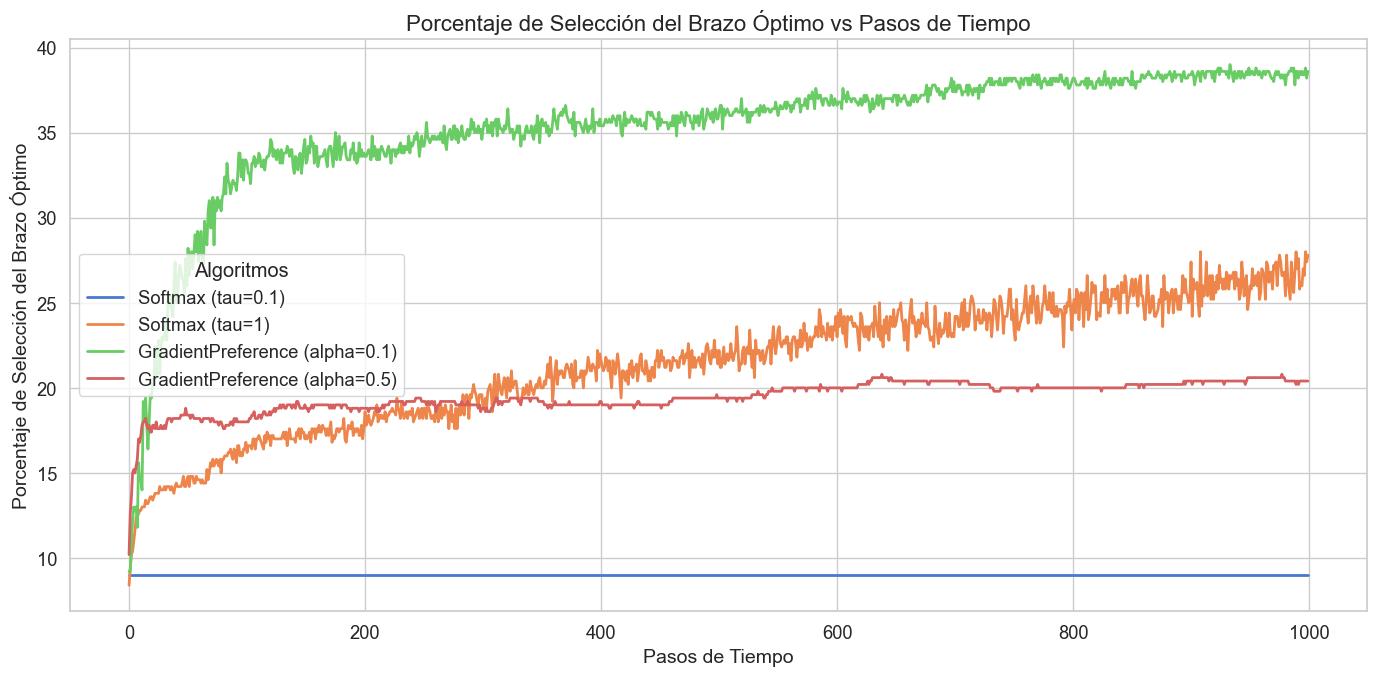

In [9]:
plot_optimal_selections(steps, optimal_selections, algorithms)

**Explicación de los Resultados: Porcentaje de Selección del Brazo Óptimo**

En la gráfica de porcentaje de selección del brazo óptimo, se observa cómo cada algoritmo selecciona el brazo con la mayor recompensa esperada a lo largo del tiempo. A continuación, se detallan los resultados obtenidos para cada configuración de los algoritmos:

- **Azul (Softmax, τ = 0.1)**:
    - Este algoritmo muestra una tendencia a seleccionar el brazo óptimo con una frecuencia constante a lo largo del tiempo. Debido a la menor exploración (τ = 0.1), no logra identificar el brazo óptimo de manera eficiente en comparación con configuraciones con mayor exploración.

- **Naranja (Softmax, τ = 1)**:
    - Con una mayor temperatura (τ = 1), este algoritmo explora más al principio, lo que le permite identificar el brazo óptimo más rápidamente. Como resultado, el porcentaje de selección del brazo óptimo aumenta más rápidamente en comparación con τ = 0.1.

- **Verde (Gradiente de Preferencias, α = 0.1)**:
    - Este algoritmo ajusta sus preferencias de manera más lenta debido a la menor tasa de aprendizaje (α = 0.1). Aunque eventualmente converge a seleccionar el brazo óptimo con mayor frecuencia, lo hace a un ritmo más lento que el Gradiente de Preferencias con α = 0.5.

- **Rojo (Gradiente de Preferencias, α = 0.5)**:
    - Con una tasa de aprendizaje más alta (α = 0.5), este algoritmo ajusta sus preferencias rápidamente, lo que le permite identificar y seleccionar el brazo óptimo con mayor frecuencia desde etapas tempranas del experimento. Esto se refleja en un rápido aumento en el porcentaje de selección del brazo óptimo.

**Conclusiones**:

1. **Exploración vs Explotación**:
     - Los algoritmos con mayor exploración inicial (Softmax con τ = 1 y Gradiente de Preferencias con α = 0.5) identifican el brazo óptimo más rápidamente y, por lo tanto, muestran un aumento más rápido en el porcentaje de selección del brazo óptimo.
     - Los algoritmos con menor exploración (Softmax con τ = 0.1 y Gradiente de Preferencias con α = 0.1) tardan más en identificar el brazo óptimo, lo que se refleja en un aumento más lento en el porcentaje de selección del brazo óptimo.

2. **Convergencia**:
     - Todos los algoritmos eventualmente convergen a seleccionar el brazo óptimo con alta frecuencia, pero la velocidad de convergencia varía según el grado de exploración y la tasa de aprendizaje.
     - El Gradiente de Preferencias con α = 0.5 muestra la convergencia más rápida, seguido por Softmax con τ = 1, Gradiente de Preferencias con α = 0.1 y finalmente Softmax con τ = 0.1.

3. **Aplicaciones Prácticas**:
     - En aplicaciones donde es crucial identificar rápidamente la mejor opción (por ejemplo, recomendaciones personalizadas, optimización de anuncios), los algoritmos con mayor exploración inicial y rápida adaptación (como Gradiente de Preferencias con α = 0.5) son más efectivos.
     - Un balance adecuado entre exploración y explotación es esencial para maximizar la recompensa a largo plazo y asegurar que el algoritmo no se quede atrapado en una elección subóptima.